# P6 - Classifiez automatiquement des biens de consommation

## Partie 1 : Prétraitement - Feature extraction - Faisaibilité

# ATTENTION

**Pour des raisons de manque d'espace dans le dépot de livrable Openclassrooms, le dossier Flipkart contenant les images et le CSV est stocké dans un google drive à cette adresse :**

## Objectif 1 : Etude de faisabilité

- **Entreprise:** "Place de marché” -> Souhaite lancer une marketplace e-commerce
- **Objectif:** Optimiser la tache de classification d'images
- Extraction de **features texte**
    - Type “bag-of-words”, **comptage simple de mots** et **Tf-idf**
    - Embedding classique avec **Word2Vec** (ou **Glove** ou **FastText**)
    - Embedding avec **BERT**
    - Embedding avec **USE (Universal Sentence Encoder)** 
- Exraction de **features images**
    - **SIFT** (Regarder le webinaire dans ressources) / **ORB** / **SURF**
    - **CNN Transfer Learning**
- Réduction en 2 dimensions -> Projeter les produits sur un graphique 2D
    - Forme de points dont la couleur correspondra à la catégorie réelle
    - Analyse du graphique afin d’en déduire (ou pas), la faisabilité de regrouper automatiquement des produits de même catégorie
    - Calculer la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters
    - **Pourrais-tu nous démontrer, par cette approche, la faisabilité de regrouper automatiquement des produits de même catégorie ?**  
    
**Normalement il y'a bien une faisabilité sur le regroupement automatiqueme des produits de même catégorie**

## Objectif 2 : Classification supervisée d'images

- Mise en place d'une **data augmentation** -> optimiser le modèle
- Souhait d'élargir leur gamme de produits, en particulier dans l’épicerie fine:
    - Collecter les produits à base de “champagne” via l’API suivante: https://rapidapi.com/edamam/api/edamam-food-and-grocery-database 
    - Extraction des 10 premiers produits dans un fichier “.csv”,
    - Chaque produit aura les données suivantes : foodId, label, category, foodContentsLabel, image.

## Notebooks

- **Notebook 1:** Prétraitement + feature extraction (textes et image) + Etude de faisabilité 
- **Notebook 2:** Classification supervisée d'images
- **Notebook 3:** Data augmentation?
- **Notebook 4:** Script Python pour tester l'API + extraction des produits

# Imports et configs

In [1]:
# Librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# pd.set_option('display.max_columns', 100)

In [2]:
# Configuration graphique
sns.set_theme(
    style='whitegrid',
    palette='pastel',
    font='helvetica',
    font_scale=1.1,
    rc={
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'grid.color': 'gray',
        'grid.linestyle': '--',
        'grid.alpha': 0.3,
        'axes.edgecolor': 'black',
        'axes.spines.left': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'axes.spines.bottom': False
    }
)

def remove_spines(ax):
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

palette = sns.color_palette()

### Chargement des dataframes (pour ne pas a devoir refaire les calculs)

In [3]:
images_features = pd.read_csv('images_features.csv', sep = ",")
df_use = pd.read_csv('df_use.csv', sep = ",")
df_bert = pd.read_csv('df_bert.csv', sep = ",")
df_word2vec = pd.read_csv('df_word2vec.csv', sep = ",")
df_bow_tf_idf = pd.read_csv('df_bow_tf_idf.csv', sep = ",")
df_bow_comptage = pd.read_csv('df_bow_comptage.csv', sep = ",")
df = pd.read_csv('df.csv', sep = ",")

In [4]:
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [5]:
df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


# Fonctions utiles

Permet de visualiser les tokens les plus courants dans une cellule

In [6]:
from collections import Counter

def visualize_tokens(df, column_name):
    # Ici nous supposons que df[column_name] est une série de chaînes de caractères
    # Tokenisation à l'aide de la méthode split() pour un exemple simple
    tokens = [token for text in df[column_name].tolist() for token in (text.split() if isinstance(text, str) else text)]
    token_freq = Counter(tokens)
    common_tokens = token_freq.most_common(10)
    tokens, freqs = zip(*common_tokens)
    plt.figure(figsize=(12,3))
    plt.bar(tokens, freqs)
    plt.title(f"Les tokens les plus courants dans la colonne {column_name}")

Effectue un search-grid sur les hyperparamètres du T-SNE

In [7]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score

def tsne_grid_search(df):
    # Les valeurs de perplexity qu'on peut éssayer
    perplexities = range(5, 101, 5)

    # Les valeurs de learning_rate qu'on peut éssayer
    learning_rates = [10, 100, 1000]

    # Les valeurs pour metric
    metrics = ['euclidean', 'manhattan', 'chebyshev']

    # Les valeurs pour init
    inits = ['random', 'pca']

    # Calcul du nombre total de combinaisons
    total_combinations = len(perplexities) * len(learning_rates) * len(metrics) * len(inits)

    # DataFrame pour stocker les résultats
    results_df = pd.DataFrame(columns=['Perplexity', 'LearningRate', 'Metric', 
                                       'Init', 'Silhouette', 'DaviesBouldin'])

    # Boucle sur toutes les combinaisons possibles
    for perp in perplexities:
        for lr in learning_rates:
            for metric in metrics:
                for init in inits:
                    tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, 
                                early_exaggeration=12.0, max_iter=1000, 
                                metric=metric, init=init, method='barnes_hut', random_state=42)
                    tsne_results = tsne.fit_transform(df.drop(columns=['category_lvl_1', 'uniq_id']))

                    # Calculer les scores pour cette configuration
                    sil_score = silhouette_score(tsne_results, df['category_lvl_1'])
                    db_score = davies_bouldin_score(tsne_results, df['category_lvl_1'])

                    # Créer un DataFrame temporaire avec les résultats
                    temp_df = pd.DataFrame([{'Perplexity': perp, 'LearningRate': lr, 
                                             'Metric': metric, 'Init': init, 
                                             'Silhouette': sil_score, 
                                             'DaviesBouldin': db_score}])

                    # Ajouter les résultats dans le DataFrame en utilisant concat
                    results_df = pd.concat([results_df, temp_df], ignore_index=True)

                    # Afficher l'avancement
                    print(f"Combinaison {len(results_df)} sur {total_combinations} effectuée.", end='\r', flush=True)

    # Calculer les rangs
    results_df['Rank_Silhouette'] = results_df['Silhouette'].rank(ascending=False)
    results_df['Rank_DaviesBouldin'] = results_df['DaviesBouldin'].rank()

    # Calculer la moyenne des rangs
    results_df['Rank_Mean'] = results_df[['Rank_Silhouette', 'Rank_DaviesBouldin']].mean(axis=1)

    # Trier le DataFrame en fonction du Rank_Mean et afficher les 10 premiers résultats
    results_df.sort_values('Rank_Mean', inplace=True)
    
    return results_df.head(10)

# Reformatage de la colonne "product_category_tree"

Notre target se situe dans "product_category_tree" qui peut être facilement simplifiée en créant un "main_category"

In [8]:
df['product_category_tree'] = df['product_category_tree'].str.strip('["]')  # enlever les crochets et guillemets
df['product_category_tree'] = df['product_category_tree'].str.split(' >> ')  # diviser les chaînes de caractères

df['category_lvl_1'] = df['product_category_tree'].apply(lambda x: x[0] if len(x) > 0 else None)
df['category_lvl_2'] = df['product_category_tree'].apply(lambda x: x[1] if len(x) > 1 else None)
df['category_lvl_3'] = df['product_category_tree'].apply(lambda x: x[2] if len(x) > 2 else None)

In [9]:
# Supprimer les colonnes spécifiées du DataFrame
columns_to_drop = [
    "crawl_timestamp",
    "product_url",
    "product_category_tree",
    "pid",
    "retail_price",
    "discounted_price",
    "is_FK_Advantage_product",
    "product_rating",
    "overall_rating",
    "product_specifications"
]

df.drop(columns=columns_to_drop, inplace=True)

In [10]:
df.head(3)

,uniq_id,product_name,image,description,brand,category_lvl_1,category_lvl_2,category_lvl_3
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,Curtains & Accessories,Curtains
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care,Baby Bath & Skin,Baby Bath Towels
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care,Baby Bath & Skin,Baby Bath Towels


In [11]:
df.to_csv('df.csv', index=False)

In [12]:
# Utilisation de la méthode 'nunique()' pour chaque colonne
nb_unique_category_lvl_1 = df['category_lvl_1'].nunique()
nb_unique_category_lvl_2 = df['category_lvl_2'].nunique()
nb_unique_category_lvl_3 = df['category_lvl_3'].nunique()

print("Nb valeurs uniques 'category_lvl_1':", nb_unique_category_lvl_1)
print("Nb valeurs uniques 'category_lvl_2':", nb_unique_category_lvl_2)
print("Nb valeurs uniques 'category_lvl_3':", nb_unique_category_lvl_3)

Nb valeurs uniques 'category_lvl_1': 7
Nb valeurs uniques 'category_lvl_2': 62
Nb valeurs uniques 'category_lvl_3': 241


## Référentiel d'évaluation

### Prétraiter des données textes pour obtenir un jeu de données exploitable

#### CE1 Vous avez nettoyé les champs de texte (suppression de la ponctuation et des mots de liaison, mise en minuscules)

- *mots de liaison = stop words*
- On va aussi supprimer les apostrophes

In [13]:
import nltk

In [14]:
from nltk.corpus import stopwords
from string import punctuation

# Définition des stop words en anglais
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Suppression de la ponctuation et mise en minuscules
    text = ''.join([c for c in text if c not in punctuation])
    text = text.lower()
    # Suppression des stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [15]:
df['description_cleaned'] = df['description'].apply(clean_text)

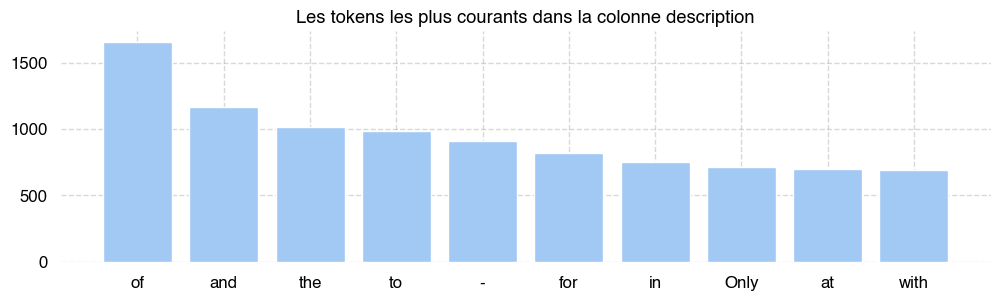

In [16]:
visualize_tokens(df, "description")

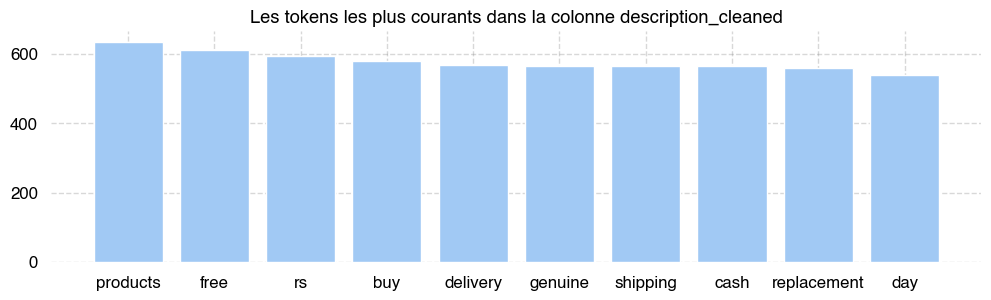

In [17]:
visualize_tokens(df, "description_cleaned")

#### CE2 Vous avez écrit une fonction permettant de “tokeniser” une phrase.

*On va ajouter la possibilité de supprimer les apostrophes aussi*

In [18]:
from nltk.tokenize import word_tokenize

# Fonction de tokenisation
def tokenize(text):
    # Suppression des apostrophes
    text = text.replace("’", "")
    return word_tokenize(text)

In [19]:
df['description_cleaned'] = df['description_cleaned'].apply(tokenize)

#### CE3 Vous avez écrit une fonction permettant de “stemmer” une phrase.

In [20]:
from nltk.stem import PorterStemmer

# Initialiser le stemmer
stemmer = PorterStemmer()

def apply_stemmer(tokens):
    return [stemmer.stem(token) for token in tokens]

In [21]:
df['description_stemmed'] = df['description_cleaned'].apply(apply_stemmer)

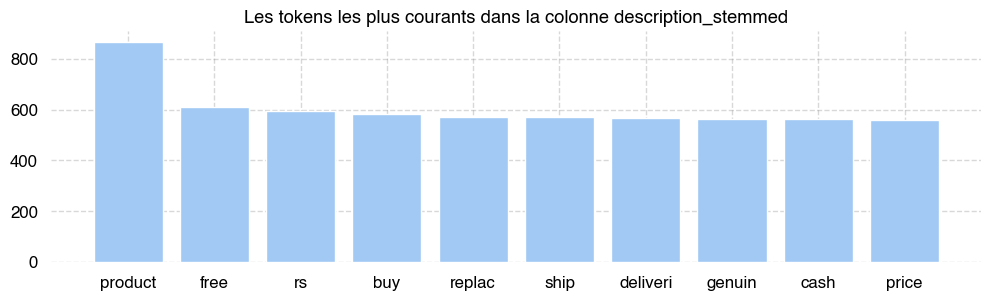

In [22]:
visualize_tokens(df, "description_stemmed")

#### CE4 Vous avez écrit une fonction permettant de “lemmatiser” une phrase.

In [23]:
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to apply lemmatization to a list of tokens
def apply_lemmatizer(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

In [24]:
# Apply the function to the DataFrame
df['description_lemmatized'] = df['description_cleaned'].apply(apply_lemmatizer)

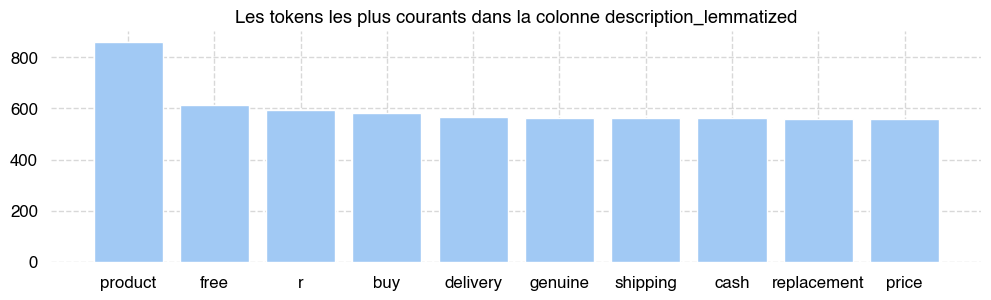

In [25]:
visualize_tokens(df, "description_lemmatized")

**La lemmatisation prend en compte le contexte et la partie du discours des mots, ce qui lui permet de produire des résultats plus précis que le stemming**

*On va garder par conséquent la lemmatisation*

In [26]:
df['description_cleaned'] = df['description_lemmatized']
df = df.drop(columns=["description_stemmed", "description_lemmatized"])

#### CE5 Vous avez construit des features ("feature engineering") de type bag-of-words (bag-of-words standard : comptage de mots, et Tf-idf), avec des étapes de nettoyage supplémentaires : seuil de fréquence des mots, normalisation des mots.

### Normalisation des mots

Déja effectué avec la lemmatisation

### Seuil de fréquence des mots

*On va tout d'abord supprimer les mots ayant qu'une seule lettre ou 2*

In [27]:
# Affiche le nombre total de mots avant suppression
count_before = df['description_cleaned'].apply(lambda x: len(x)).sum()
print("Nombre de mots avant suppression: ", count_before)

# Affiche le nombre de mots uniques avant suppression
unique_words = set(word for doc in df['description_cleaned'] for word in doc)
unique_count_after = len(unique_words)
print("Nombre de mots uniques avant suppression: ", unique_count_after)

# Supprimer les mots de une lettre ou 2
df['description_cleaned'] = df['description_cleaned'].apply(lambda x: [word for word in x if len(word) > 2])

# Nombre total de mots après suppression
count_after = df['description_cleaned'].apply(lambda x: len(x)).sum()
print("Nombre de mots après suppression: ", count_after)

# Nombre de mots uniques dans l'ensemble du corpus après suppression
unique_words = set(word for doc in df['description_cleaned'] for word in doc)
unique_count_after = len(unique_words)
print("Nombre de mots uniques après suppression: ", unique_count_after)

Nombre de mots avant suppression:  59088
Nombre de mots uniques avant suppression:  6157
Nombre de mots après suppression:  54417
Nombre de mots uniques après suppression:  5976


Regardons la distribution des mots:

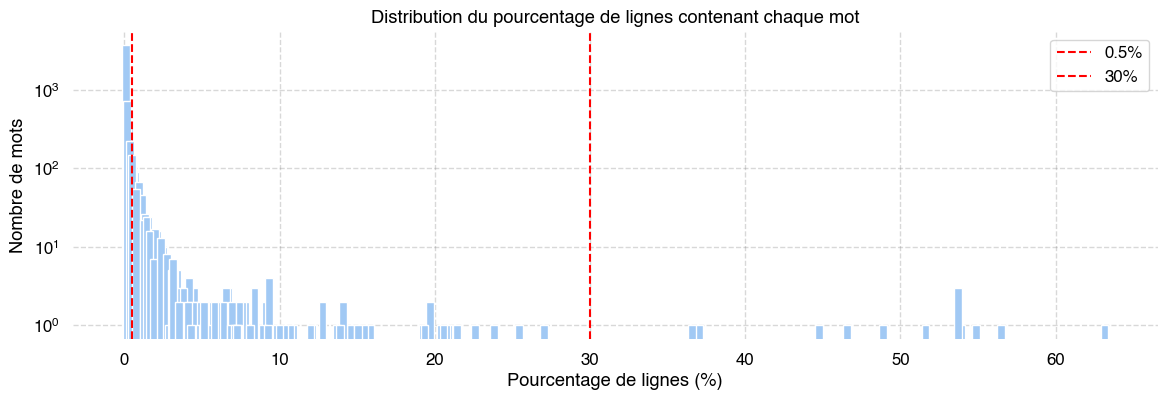

In [28]:
# Créer une colonne pour les ensembles de mots uniques dans chaque description
df['unique_tokens'] = df['description_cleaned'].apply(set)

# Recueillir tous les mots uniques à partir des ensembles de mots uniques
unique_words = set(word for word_set in df['unique_tokens'] for word in word_set)

# Compter le nombre de lignes contenant chaque mot unique
word_counts = {word: sum(df['unique_tokens'].apply(lambda x: word in x)) for word in unique_words}

# Créer un dataframe à partir du dictionnaire de comptage des mots
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])

# Convertir le compte en pourcentage
word_counts_df['percentage'] = word_counts_df['count'] / len(df) * 100

# Calculer la distribution des pourcentages de lignes
percentage_counts = Counter(word_counts_df['percentage'])

# Créer un diagramme à barres à partir de cette distribution
plt.figure(figsize=(14, 4))
plt.bar(percentage_counts.keys(), percentage_counts.values(), width=0.5)
plt.xlabel('Pourcentage de lignes (%)')
plt.ylabel('Nombre de mots')
plt.title('Distribution du pourcentage de lignes contenant chaque mot')

# Changer l'axe des ordonnées en échelle logarithmique
plt.yscale('log')

# Ajouter des traits rouges verticaux pour 0.1% et 50%
plt.axvline(0.5, color='red', linestyle='--', label='0.5%')
plt.axvline(30, color='red', linestyle='--', label='30%')

# Afficher la légende
plt.legend()

plt.show()

In [29]:
# On convertit chaque ligne en un ensemble pour supprimer les doublons
unique_words_per_line = df['description_cleaned'].apply(set)

# On convertit la colonne des ensembles en une liste de mots
words_list = [word for sublist in unique_words_per_line.tolist() for word in sublist]

# On compte le nombre de lignes où chaque mot apparaît
counter = Counter(words_list)

# On extrait les 10 mots les plus courants
most_common_words = counter.most_common(10)

# On crée un nouveau DataFrame pour stocker les résultats
result_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

# On calcule le pourcentage d'apparition de chaque mot
result_df['percentage'] = (result_df['count'] / len(df)) * 100

result_df

,word,count,percentage
0,product,663,63.142857
1,free,593,56.476190
2,buy,576,54.857143
3,delivery,566,53.904762
4,cash,564,53.714286
5,genuine,564,53.714286
6,shipping,564,53.714286
7,price,542,51.619048
8,day,513,48.857143
9,replacement,489,46.571429


- Les mots les plus utilisés sont en général des mots assez génériques
- Les mots les moins courants ne peuvent pas être utiles pour généraliser à de nouvelles descriptions de produits

In [30]:
# Affiche le nombre total de mots avant suppression
count_before = df['description_cleaned'].apply(lambda x: len(x)).sum()
print("Nombre de mots avant suppression: ", count_before)

# Affiche le nombre de mots uniques avant suppression
unique_words = set(word for doc in df['description_cleaned'] for word in doc)
unique_count_after = len(unique_words)
print("Nombre de mots uniques avant suppression: ", unique_count_after)

# Créer une colonne pour les ensembles de mots uniques dans chaque description
df['unique_tokens'] = df['description_cleaned'].apply(set)

# Recueillir tous les mots uniques à partir des ensembles de mots uniques
unique_words = set(word for word_set in df['unique_tokens'] for word in word_set)

# Compter le nombre de lignes contenant chaque mot unique
word_counts = {word: sum(df['unique_tokens'].apply(lambda x: word in x)) for word in unique_words}

# Créer un dataframe à partir du dictionnaire de comptage des mots
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])

# Convertir le compte en pourcentage
word_counts_df['percentage'] = word_counts_df['count'] / len(df) * 100

# Filtrer les mots qui apparaissent dans moins de 0.5% des lignes et dans plus de 30% des lignes
filtered_words = word_counts_df[(word_counts_df['percentage'] >= 0.5) & (word_counts_df['percentage'] <= 30)].index

# Filtrer les mots dans le df original
df['description_cleaned'] = df['description_cleaned'].apply(lambda tokens: [token for token in tokens if token in filtered_words])

# Nombre total de mots après suppression
count_after = df['description_cleaned'].apply(lambda x: len(x)).sum()
print("Nombre de mots après suppression: ", count_after)

# Nombre de mots uniques dans l'ensemble du corpus après suppression
unique_words = set(word for doc in df['description_cleaned'] for word in doc)
unique_count_after = len(unique_words)
print("Nombre de mots uniques après suppression: ", unique_count_after)

Nombre de mots avant suppression:  54417
Nombre de mots uniques avant suppression:  5976
Nombre de mots après suppression:  34247
Nombre de mots uniques après suppression:  818


In [31]:
unique_words = set(word for doc in df['description_cleaned'] for word in doc)
unique_count = len(unique_words)
print("Nombre de mots uniques dans l'ensemble du corpus: ", unique_count)

Nombre de mots uniques dans l'ensemble du corpus:  818


### bag-of-words standard : comptage de mots

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

def do_nothing(tokens):
    return tokens

vectorizer = CountVectorizer(analyzer=do_nothing, lowercase=False)
X = vectorizer.fit_transform(df['description_cleaned'])
feature_names = vectorizer.get_feature_names_out()

In [33]:
df_bow_comptage = pd.DataFrame(X.toarray(), columns=feature_names)

In [34]:
df_bow_comptage.to_csv('df_bow_comptage.csv', index=False)

In [35]:
df_bow_comptage.head()

,100,121,1299,141,1499,150,156,1799,180,195,...,wooden,work,world,would,wrap,year,yellow,yes,yet,youre
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### bag-of-words standard : Tf-idf

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convertir la liste de tokens en chaînes de caractères
corpus = df['description_cleaned'].apply(' '.join)

vectorizer = TfidfVectorizer(preprocessor=lambda x: x)
X = vectorizer.fit_transform(corpus)

# Crée un DataFrame avec les scores TF-IDF
df_bow_tf_idf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

In [37]:
df_bow_tf_idf.to_csv('df_bow_tf_idf.csv', index=False)

In [38]:
df_bow_tf_idf.head()

,100,121,1299,141,1499,150,156,1799,180,195,...,wooden,work,world,would,wrap,year,yellow,yes,yet,youre
0,0.048438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.067218,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.199095,0.076750,0.0,0.0
2,0.095450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.050556,0.000000,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.047848,0.0,0.0
4,0.083822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.038220,0.0,0.0


#### CE6 Vous avez testé une phrase ou un court texte d'exemple, pour illustrer la bonne réalisation des 5 étapes précédentes.

In [39]:
data = {
    'texte': ["Jim is my enemy. But it turns out that Jim is also his own worst enemy. And the enemy of my enemy is my friend. So Jim, is actually my friend. But, because he is his own worst enemy, the enemy of my friend is my enemy so actually Jim is my enemy."]
}

# Créez le dataframe à partir du dictionnaire
df_exemple = pd.DataFrame(data)

# Affichez le dataframe
print(df_exemple["texte"])

0    Jim is my enemy. But it turns out that Jim is ...
Name: texte, dtype: object


**Cleaning**

In [40]:
# Application de la fonction de nettoyage
print(df_exemple["texte"].iloc[0])
df_exemple["clean_texte"] = df_exemple["texte"].apply(clean_text)
print('')
print(df_exemple["clean_texte"].iloc[0])

Jim is my enemy. But it turns out that Jim is also his own worst enemy. And the enemy of my enemy is my friend. So Jim, is actually my friend. But, because he is his own worst enemy, the enemy of my friend is my enemy so actually Jim is my enemy.

jim enemy turns jim also worst enemy enemy enemy friend jim actually friend worst enemy enemy friend enemy actually jim enemy


**Tokenization**

In [41]:
print(df_exemple["clean_texte"].iloc[0])
df_exemple["clean_texte"] = df_exemple["clean_texte"].apply(tokenize)
print('')
print(df_exemple["clean_texte"].iloc[0])

jim enemy turns jim also worst enemy enemy enemy friend jim actually friend worst enemy enemy friend enemy actually jim enemy

['jim', 'enemy', 'turns', 'jim', 'also', 'worst', 'enemy', 'enemy', 'enemy', 'friend', 'jim', 'actually', 'friend', 'worst', 'enemy', 'enemy', 'friend', 'enemy', 'actually', 'jim', 'enemy']


**Steamming**

In [42]:
print(df_exemple["clean_texte"].iloc[0])
df_exemple["clean_texte_stemmed"] = df_exemple["clean_texte"].apply(apply_stemmer)
print('')
print(df_exemple["clean_texte_stemmed"].iloc[0])

['jim', 'enemy', 'turns', 'jim', 'also', 'worst', 'enemy', 'enemy', 'enemy', 'friend', 'jim', 'actually', 'friend', 'worst', 'enemy', 'enemy', 'friend', 'enemy', 'actually', 'jim', 'enemy']

['jim', 'enemi', 'turn', 'jim', 'also', 'worst', 'enemi', 'enemi', 'enemi', 'friend', 'jim', 'actual', 'friend', 'worst', 'enemi', 'enemi', 'friend', 'enemi', 'actual', 'jim', 'enemi']


**Lemmatisation**

In [43]:
print(df_exemple["clean_texte"].iloc[0])
df_exemple["clean_texte_lemmatized"] = df_exemple["clean_texte"].apply(apply_lemmatizer)
print('')
print(df_exemple["clean_texte_lemmatized"].iloc[0])

['jim', 'enemy', 'turns', 'jim', 'also', 'worst', 'enemy', 'enemy', 'enemy', 'friend', 'jim', 'actually', 'friend', 'worst', 'enemy', 'enemy', 'friend', 'enemy', 'actually', 'jim', 'enemy']

['jim', 'enemy', 'turn', 'jim', 'also', 'worst', 'enemy', 'enemy', 'enemy', 'friend', 'jim', 'actually', 'friend', 'worst', 'enemy', 'enemy', 'friend', 'enemy', 'actually', 'jim', 'enemy']


In [44]:
df_exemple['clean_texte'] = df_exemple['clean_texte_lemmatized']
df_exemple = df_exemple.drop(columns=["clean_texte_stemmed", "clean_texte_lemmatized"])

In [45]:
df_exemple

,texte,clean_texte
0,Jim is my enemy. But it turns out that Jim is ...,"[jim, enemy, turn, jim, also, worst, enemy, en..."


**Seuil de fréquence des mots:**

Pas trop besoin, ici tout le corpus n'est que dans une ligne

**bag-of-words standard : comptage de mots**

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

def do_nothing(tokens):
    return tokens

vectorizer = CountVectorizer(analyzer=do_nothing, lowercase=False)
X = vectorizer.fit_transform(df_exemple['clean_texte'])
feature_names = vectorizer.get_feature_names_out()

In [47]:
df_bow_comptage_exemple = pd.DataFrame(X.toarray(), columns=feature_names)

In [48]:
df_bow_comptage_exemple

,actually,also,enemy,friend,jim,turn,worst
0,2,1,8,3,4,1,2


**bag-of-words standard : Tf-idf**

In [49]:
# Convertir la liste de tokens en chaînes de caractères
corpus = df_exemple['clean_texte'].apply(' '.join)

vectorizer = TfidfVectorizer(preprocessor=lambda x: x)
X = vectorizer.fit_transform(corpus)

# Crée un DataFrame avec les scores TF-IDF
df_bow_tf_idf_exemple = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=df_exemple.index)

In [50]:
df_bow_tf_idf_exemple

,actually,also,enemy,friend,jim,turn,worst
0,0.201008,0.100504,0.80403,0.301511,0.402015,0.100504,0.201008


#### CE7 Vous avez, en complément de la démarche de type “bag-of-words”, mis en oeuvre 3 démarches de word/sentence embedding : Word2Vec (ou Doc2Vec ou Glove ou FastText), BERT, et USE (Universal Sentence Encoder).

**Word2Vec:**
- Représente les mots dans un espace vectoriel continu. Cela permet de capturer les relations sémantiques entre les mots. 
- Il existe deux architectures principales dans Word2Vec : **Skip-Gram** et **Continuous Bag of Words (CBOW)**.
    - **Skip-Gram:** Généralisation des n-grammes dans laquelle les mots ne sont pas obligés d’être consécutifs lors de la classification de texte
    - **CBOW:** Utilise un réseau neuronal pour générer des plongements de mots en prédisant un mot cible en fonction de ses mots contextuels environnants

**Doc2Vec:**

- Étend Word2Vec en ajoutant un vecteur supplémentaire pour représenter un document entier. 
- Cela permet de capturer la sémantique non seulement des mots mais aussi des phrases ou des documents.

**GloVe (Global Vectors for Word Representation):**
- Se base sur la matrice de cooccurrence des mots
- Optimise une fonction de perte pour que le produit scalaire des vecteurs de mots corresponde à la log-probabilité de cooccurrence.

**FastText:**
- Similaire à Word2Vec, mais prend en compte les sous-mots (comme les caractères ou les n-grammes de caractères) 
- Cela permet une meilleure gestion des mots rares et des mots non présents dans le vocabulaire d'entraînement.

*On va utiliser Word2Vec car c'est celui qui est le mieux adapté pour une version tokenisé de nos documents*

### Word2Vec

Word2Vec possède 3 hyperparamètres:

- **vector_size:** Dimensionnalité des vecteurs de mots
- **window:** Nombre de mots autour du mot cible à considérer
- **min_count:** Nombre minimal d'occurrences d'un mot dans le corpus pour qu'il soit inclus dans le modèle

Pour l'instant ca va être compliqué de trouver les bonnes valeurs, on va prendre celles couremment utilisés

In [51]:
from gensim.models import Word2Vec

# Hyperparamètres
vector_size = 100
window_size = 5
min_count = 5

# Entrainement du word2vec_model
word2vec_model = Word2Vec(sentences=df['description_cleaned'], vector_size=vector_size, window=window_size, min_count=min_count)

In [52]:
# Résumé du modèlel
word2vec_model.get_latest_training_loss(), word2vec_model.wv.vectors.shape

(0.0, (818, 100))

On va transformer ces 818 mots en un vecteur de 100 dimensions

In [53]:
# Function to convert a list of words into a vector by taking the mean of the word vectors
def description_to_vector(description, model):
    vectors = [model.wv[word] for word in description if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Applying the function to the "description_cleaned" column
description_vectors = df['description_cleaned'].apply(lambda x: description_to_vector(x, word2vec_model))

# Converting the result to a DataFrame
df_word2vec = pd.DataFrame(description_vectors.tolist())

In [54]:
df_word2vec.to_csv('df_word2vec.csv', index=False)

In [55]:
# Displaying the first few rows of the resulting DataFrame
display(df_word2vec.head())
print(df_word2vec.shape[0], df_word2vec.shape[1])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.016329,0.092322,0.105712,0.202667,0.141701,-0.433454,0.008235,0.542097,-0.237463,-0.036882,...,0.339213,0.090043,0.101783,0.221246,0.399791,0.090439,0.076532,-0.108066,0.068174,0.031508
1,0.025048,0.106207,0.084202,0.154838,0.183353,-0.474679,0.008952,0.616518,-0.244676,-0.056989,...,0.371209,0.144847,0.139042,0.226508,0.448515,0.069657,0.103545,-0.131848,0.082009,0.067445
2,0.020576,0.100363,0.111012,0.189946,0.140796,-0.466738,0.015988,0.566427,-0.250009,-0.037881,...,0.336724,0.107317,0.106697,0.224752,0.440857,0.092261,0.092926,-0.120821,0.079201,0.028194
3,0.018262,0.108214,0.064685,0.175611,0.194030,-0.449646,0.006891,0.597351,-0.211429,-0.072360,...,0.384019,0.122481,0.126222,0.246111,0.395848,0.046999,0.071226,-0.126189,0.055858,0.088191
4,0.018445,0.109406,0.091348,0.204533,0.169072,-0.465757,0.012665,0.596394,-0.231135,-0.056180,...,0.373076,0.106905,0.118514,0.250595,0.419917,0.072740,0.070353,-0.118238,0.060776,0.058996


1050 100


### BERT (Bidirectional Encoder Representations from Transformers)

- **Bidirectionnel:** Contrairement à Word2Vec ou GloVe, BERT prend en compte les mots qui précèdent et suivent un mot donné dans une phrase
- **Architecture transformateurs:** Emploie des mécanismes d'attention permettant au modèle de se concentrer sur différentes parties d'une phrase lors de l'analyse du sens d'un mot
- **Pré-entraînement:** BERT peut être affiné sur une tâche spécifique, telle que la classification de texte ou la réponse aux questions
- **Représentation Contextuelle:** BERT est sensible au contexte. Cela signifie que le même mot peut avoir des embeddings différents dans des phrases différentes

**L'avantage de BERT est qu'il n'est pas nécéssaire de procéder à une formalisation de notre corpus:**
- **Suppression de la ponctuation et des mots de liaison (stop words):** BERT a été entraîné sur des textes complets et non filtrés, y compris la ponctuation et les mots de liaison. La suppression de ces éléments peut en fait priver le modèle d'informations contextuelles importantes qu'il a apprises à utiliser. La ponctuation, par exemple, peut avoir un rôle significatif dans la compréhension de la structure grammaticale d'une phrase.
- **Mise en minuscules:** BERT est capable de gérer à la fois les majuscules et les minuscules, et la distinction peut porter une information sémantique.
- **Tokenization:** BERT utilise sa propre méthode de tokenization, appelée WordPiece, qui divise les mots en sous-mots ou tokens plus petits si nécessaire
- **Lemmatisation:** BERT a été formé sur des formes de mots complètes et peut perdre des informations si vous lui fournissez uniquement des lemmes

In [56]:
data = df

In [57]:
#### Importations
from transformers import BertTokenizer, BertModel
import torch
import sys

# Fonction pour obtenir les embeddings BERT d'un texte
def get_bert_embedding(text):
    # Tokenisation du texte
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
    # Exécution du modèle pour obtenir les sorties
    with torch.no_grad():
        outputs = model(**inputs)
    # Récupération des embeddings du dernier état caché
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Charger le tokenizer et le modèle BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# S'assurer que la colonne "description" ne contient pas de valeurs manquantes
data['description'] = data['description'].fillna('')

# Obtenir les embeddings BERT pour toute la colonne "description"
bert_embeddings = []
for i, desc in enumerate(data['description']):
    bert_embeddings.append(get_bert_embedding(desc))
    sys.stdout.write(f"\rTraitement de la description {i+1}/{len(data)}")
    sys.stdout.flush()

# Convertir les embeddings en DataFrame
df_bert = pd.DataFrame([embedding.flatten() for embedding in bert_embeddings])

Traitement de la description 1050/1050

In [58]:
df_bert

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.139285,-0.147112,0.584645,-0.053153,0.706819,0.024994,-0.043478,0.325798,-0.036617,-0.522964,...,0.180787,-0.272991,0.297706,-0.210983,-0.144417,-0.064212,-0.129507,-0.266790,-0.042557,-0.171184
1,0.010229,-0.123317,0.579820,0.066870,0.250622,0.032997,0.134588,0.040148,-0.046333,-0.078182,...,0.037382,-0.183965,0.240299,-0.139958,-0.014386,-0.008773,-0.404847,-0.299267,-0.198612,0.027872
2,-0.059171,-0.147463,0.507296,0.079291,0.365674,-0.155191,-0.134151,0.480830,-0.090870,-0.118901,...,-0.066508,-0.171181,0.238459,-0.251130,-0.002773,0.163428,-0.147737,-0.257123,-0.143233,-0.087481
3,0.160119,-0.207000,0.697988,0.073262,0.482203,-0.229916,-0.154855,0.153520,-0.083500,0.100411,...,0.106085,-0.139065,0.263556,-0.077329,0.031875,-0.058912,-0.524418,-0.132688,-0.008046,-0.184164
4,0.112136,-0.004882,0.430160,-0.058560,0.533653,-0.308349,-0.108745,0.420066,0.004935,-0.123929,...,0.063356,-0.082531,0.233091,-0.100965,-0.206244,0.155450,-0.409829,-0.242557,0.114111,-0.329055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.015879,-0.169814,0.543524,0.098585,0.367561,-0.179841,-0.081186,0.188141,-0.050015,-0.300034,...,0.119963,-0.104639,0.218423,-0.195343,0.045519,0.039761,-0.333340,-0.134866,-0.013250,-0.014285
1046,-0.017958,0.062859,0.735298,0.032668,0.379563,-0.106620,-0.104049,0.387391,0.132424,-0.333695,...,0.082643,-0.144481,0.156140,-0.246832,-0.016672,-0.151909,-0.219257,-0.081575,0.051865,-0.180311
1047,0.273744,-0.137377,0.489988,0.099483,0.485047,-0.243510,-0.078172,0.482547,-0.034344,0.070069,...,-0.043712,-0.267327,0.113772,-0.130057,-0.024549,-0.009567,-0.316591,-0.005686,0.088200,-0.072202
1048,0.234820,-0.113612,0.515876,0.122060,0.432797,-0.247194,0.135930,0.388674,0.122206,-0.119825,...,0.118058,-0.217978,0.324013,-0.239478,0.007814,-0.017478,-0.412561,-0.014276,0.074260,-0.248347


In [59]:
df_bert.to_csv('df_bert.csv', index=False)

### USE (Universal Sentence Encoder)

- **Vecteurs de taille fixe:** Indépendamment de la longueur de la phrase. Cela permet une comparaison facile entre différentes phrases.
- **Compréhension Sémantique:** Il peut identifier des similitudes entre des phrases qui ont le même sens mais qui sont formulées différemment
- **Architecture:** Choix entre les réseaux de neurones à transformation et les réseaux profonds pré-entraînés
- **Pré-entraîné:** On peut l'utiliser sans avoir besoin de le former vous-même. Il peut être affiné pour des tâches spécifiques si nécessaire

*Comme BERT, l'USE marche mieux sur des documents bruts plutot que tokénisés et cleanés*

In [60]:
# Importations
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import display, clear_output

# Fonction pour obtenir les embeddings USE d'un texte
def get_use_embedding(text):
    # Conversion du texte en tenseurs
    text_tensor = tf.convert_to_tensor([text])
    # Exécution du modèle pour obtenir les embeddings
    return use_model(text_tensor).numpy()

# Charger l'Universal Sentence Encoder
use_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(use_model_url)

# S'assurer que la colonne "description" ne contient pas de valeurs manquantes
data['description'] = data['description'].fillna('')

# Obtenir les embeddings USE pour toute la colonne "description"
use_embeddings = []
for i, desc in enumerate(data['description']):
    use_embeddings.append(get_use_embedding(desc))
    clear_output(wait=True)
    display(f"Traitement de la description {i+1}/{len(data)}")

# Convertir les embeddings en DataFrame
df_use = pd.DataFrame([embedding.flatten() for embedding in use_embeddings])

'Traitement de la description 1050/1050'

In [61]:
df_use.to_csv('df_use.csv', index=False)

In [62]:
df_use

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.056370,-0.023049,0.017895,0.047665,0.027025,0.050614,-0.051162,0.058017,-0.023607,-0.009930,...,-0.044671,-0.059813,-0.055564,0.050154,-0.017514,-0.042019,0.025209,0.050283,0.047570,-0.013489
1,-0.051229,-0.018987,0.012277,0.022975,0.057922,0.060340,0.057083,-0.022221,-0.047319,-0.047699,...,0.031741,-0.059948,-0.054229,-0.056525,-0.019069,-0.052220,-0.005158,0.033082,0.031539,0.034636
2,-0.058302,0.023299,-0.044487,0.054548,0.056491,0.057848,0.050587,0.044124,-0.024653,0.005472,...,0.054910,-0.058474,-0.049861,0.002297,0.014810,-0.044659,0.044119,0.057874,-0.050333,-0.046317
3,-0.055484,-0.052558,0.042706,0.052433,0.055371,0.047493,0.022774,0.032461,-0.008624,-0.051243,...,-0.019819,-0.055705,-0.007594,0.022513,-0.052632,-0.032311,0.052942,0.053591,-0.026310,-0.054579
4,-0.055115,-0.037855,0.040429,0.049555,0.055062,0.053625,-0.028349,0.051057,0.034127,-0.050300,...,0.005448,-0.055271,-0.050868,-0.026799,-0.054645,-0.040339,0.054859,0.055189,-0.019382,-0.052904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,-0.056608,0.044951,-0.019857,0.015343,0.033420,0.015135,-0.038061,0.048103,-0.060282,0.057737,...,-0.059285,-0.061977,-0.031888,0.060555,-0.061577,0.055591,-0.014485,0.053376,-0.052497,-0.047670
1046,-0.066967,-0.033571,0.002635,0.064147,0.045324,0.019860,-0.025628,0.063236,-0.043258,0.044067,...,-0.027645,-0.067885,-0.016047,0.036646,-0.025409,0.033491,0.003305,0.049515,-0.010443,-0.035477
1047,-0.044080,-0.037559,0.030473,0.027353,-0.008345,0.045602,-0.072689,0.024444,-0.051943,-0.069020,...,0.013089,-0.069779,-0.043264,0.037940,-0.064879,-0.031306,0.069748,0.014150,0.057654,-0.062780
1048,-0.046862,-0.039284,0.048987,0.052200,0.030195,0.045698,-0.069876,0.031530,-0.011628,-0.070702,...,0.051379,-0.053386,-0.042889,0.044663,-0.066084,-0.043230,0.034062,0.045094,-0.019001,-0.029463


#### CE8 Vous vous êtes assurés que le texte traité ne relève pas d’une propriété intellectuelle dont l’utilisation ou la modification est interdite.

Voici ce qui est écrit dans le "mail" de Linda (OpenClassrooms)

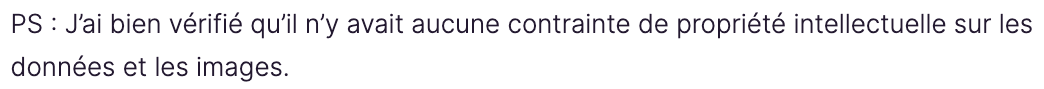

### Prétraiter des données images pour obtenir un jeu de données exploitable.

On va s'intéresser a 1 image

#### CE1 Vous avez utilisé des librairies spécialisées pour un premier traitement du contraste (ex. : openCV). 

Le traitement du contraste sera effectué dans l'égalisation (CE2)

#### CE2 Vous avez présenté des opérations de retraitement d'images (par exemple passage en gris, filtrage du bruit, égalisation, floutage) sur un ou plusieurs exemples. 

On va prendre 1 image pour exemple

- **Conversion en niveaux de gris:** La plupart des opérations de prétraitement d'image comme SIFT (Scale-Invariant Feature Transform), fonctionnent sur des images en niveaux de gris plutôt que sur des images en couleur.

- **Réduction du bruit:** Peut aider à supprimer les détails non pertinents qui pourraient interférer avec les étapes de prétraitement ultérieures.

- **Égalisation d'histogramme:** Améliore le contraste dans une image en répartissant plus uniformément les niveaux de gris dans l'histogramme de l'image

- **Floutage:** Aide à réduire encore plus le bruit et à supprimer les détails non pertinents

Nom du fichier : 009099b1f6e1e8f893ec29a7023153c4.jpg


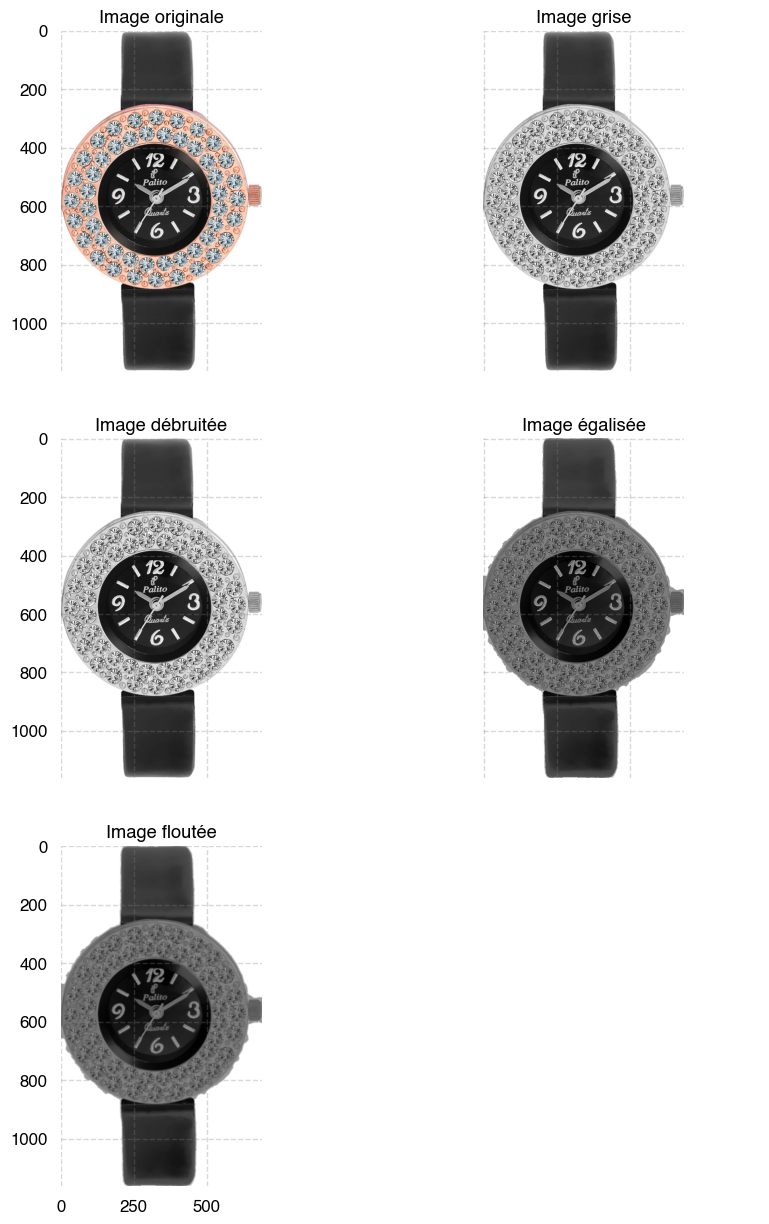

In [63]:
import os
import cv2

# Définition du nombre d'images à traiter
nb_images = 1

# Obtenez le chemin du script actuel
script_path = os.getcwd()

# Le chemin où sont les images originales
input_path = os.path.join(script_path, './Flipkart/Images')

# Le chemin où on va enregistrer les images transformées
output_path = os.path.join(script_path, './Flipkart/Images_pretraitement')

# Si le dossier de sortie n'existe pas, le créer
if not os.path.exists(output_path):
    os.makedirs(output_path)

# On récupère les nb_images premières images dans le dossier
image_files = sorted([f for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f))])[:nb_images]

# On traite chaque image individuellement
for image_file in image_files:
    # Nom du fichier
    print(f"Nom du fichier : {image_file}")
    
    # Lire l'image en couleur
    image = cv2.imread(os.path.join(input_path, image_file))

    # Conversion en gris
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Filtrage du bruit
    denoised_image = cv2.fastNlMeansDenoising(gray_image)

    # Égalisation
    equalized_image = cv2.equalizeHist(denoised_image)
    
    # Floutage
    blurred_image = cv2.GaussianBlur(equalized_image, (7, 7), 0)

    # Enregistrement de l'image transformée
    cv2.imwrite(os.path.join(output_path, image_file), blurred_image)

    # Affichage de l'image originale et l'image transformée
    fig, axs = plt.subplots(3, 2, figsize=(10, 15))
    axs[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title('Image originale')
    axs[0, 1].imshow(gray_image, cmap='gray')
    axs[0, 1].set_title('Image grise')
    axs[1, 0].imshow(denoised_image, cmap='gray')
    axs[1, 0].set_title('Image débruitée')
    axs[1, 1].imshow(equalized_image, cmap='gray')
    axs[1, 1].set_title('Image égalisée')
    axs[2, 0].imshow(blurred_image, cmap='gray')
    axs[2, 0].set_title('Image floutée')
    for ax in axs.flat:
        ax.label_outer()
    for ax in axs.flat:
        ax.label_outer()
    axs[2, 1].axis('off') # Cacher le dernier plot
    plt.show()

#### CE3 Vous avez élaboré une fonction permettant d'extraire des features ("feature engineering") de type "bag-of-images" via la génération de descripteurs (algorithmes ORB, ou SIFT, ou SURF). 

J'ai utilisé SIFT pour cette image

In [64]:
import cv2
import os

# Définissez le chemin d'accès relatif à votre image
image_path = "./Flipkart/Images_pretraitement/009099b1f6e1e8f893ec29a7023153c4.jpg"

# Charger l'image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Créer un objet SIFT
sift = cv2.SIFT_create()

# Détecter et calculer les points clés et les descripteurs
keypoints, descriptors = sift.detectAndCompute(image, None)

# Afficher les points clés sur l'image
image = cv2.drawKeypoints(image, keypoints, None)

# Enregistrez l'image avec des points clés
cv2.imwrite('sift_keypoints.jpg',image)

# Si vous voulez enregistrer les descripteurs pour une utilisation ultérieure
np.save('sift_descriptors.npy', descriptors)

# Imprimer le nombre de points clés
print("Nombre de features clés : ", len(keypoints))

Nombre de features clés :  2092


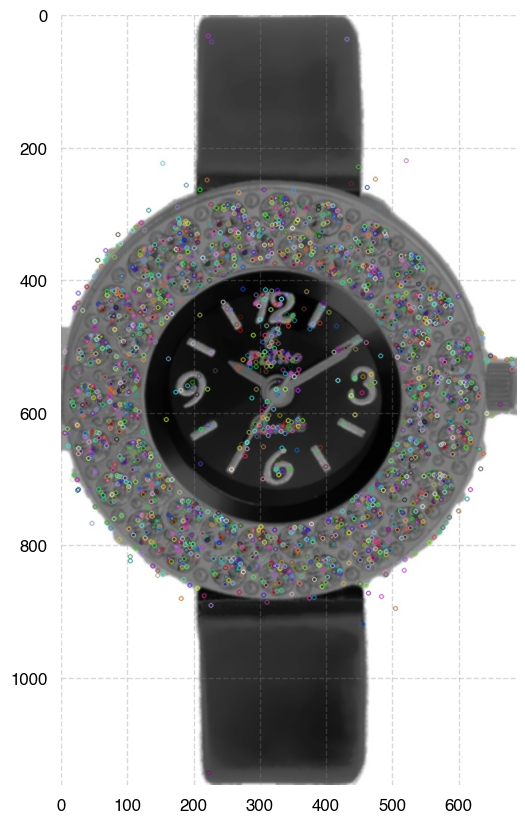

In [65]:
# Lire l'image avec les keypoints
sift_image = cv2.imread('sift_keypoints.jpg')

# Convertir l'image en RGB pour l'affichage avec matplotlib
sift_image = cv2.cvtColor(sift_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(sift_image)
plt.show()

#### CE4 Vous avez élaboré et exécuté une fonction permettant d'extraire des features ("feature engineering") via un algorithme de Transfer Learning basé sur des réseaux de neurones, comme par exemple CNN. 

### Chargement du modèle CNN

On va utiliser VGG16 ici

- **VGG16:** est une architecture "Convolutional Neural Network" 
- Ce modèle a été entrainé sur plus d'un million d'images et peut classer les images en 1000 classes d'objets.

In [66]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


- On construit un nouveau modèle qui reprend l'architecture de VGG16, mais sans la dernière couche
- Ici, "-2" indique que l'on s'intéresse à l'avant-dernière couche du modèle VGG16.
    - C'est une façon courante d'effectuer le "transfer learning"
    - On utilise les couches inférieures d'un réseau pré-entraîné pour extraire des caractéristiques, 
    - Et on ajoute nos propres couches de haut niveau pour des tâches spécifiques.

### Extraction des features sur nos images

- Les images brutes n'ont pas besoin d'énormément de prétraitement pour être utilisés sur VGG-16
    - On doit redimensionner les images à la taille 224x224
    - On Réequilibre les couleurs RGB

In [67]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image

# Pour charger des images de grande taille
Image.MAX_IMAGE_PIXELS = None

# Initialiser une liste vide pour stocker les caractéristiques des images
images_features = []
images_names = []
i=0 

# Obtenir la liste des noms de fichiers dans le dossier "Images"
image_files = os.listdir("./Flipkart/Images")

# Boucler sur chaque fichier dans le dossier
for image_file in image_files:
    
    # Afficher le compteur chaque fois qu'il est divisible par 100 pour suivre la progression
    if i%100 == 0 : print(i)
    
    # Incrementer le compteur
    i +=1
    
    # Construire le chemin de l'image
    image_file_path = os.path.join("Flipkart", "Images", image_file)
    
    # Vérifier que c'est un fichier (et non un répertoire)
    if not os.path.isfile(image_file_path):
        continue
    
    # Redimensionner l'image à la taille de 224x224 car VGG16 accepte les images de cette taille
    image = load_img(image_file_path, target_size=(224, 224))
    
    # Convertir l'image chargée en tableau numpy pour pouvoir la manipuler
    image = img_to_array(image) 
    
    # 3D -> 4D car VGG16 est un tenseur 4D avec la forme (batch_size, height, width, channels)
    image = np.expand_dims(image, axis=0)
    
    # Rééquilibrage des couleurs RGB pour correspondre à ce que VGG16 attend
    image = preprocess_input(image)
    
    # Extraction des images
    image_feature = model.predict(image, verbose=0)[0]
    
    # Ajout des caractéristiques et du nom de l'image dans les listes correspondantes
    images_features.append(image_feature)
    images_names.append(image_file)

# Convertir la liste des caractéristiques des images en DataFrame pandas pour une manipulation plus facile
images_features = pd.DataFrame(images_features)

# Ajouter une nouvelle colonne avec les noms des images
images_features['image'] = images_names

0


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


100
200
300
400
500
600
700
800
900
1000


In [68]:
images_features = pd.merge(df, images_features, on='image', how='inner')

In [69]:
columns_to_remove = ['product_name', 'image', 'description', 'brand', 'category_lvl_2', 'category_lvl_3', 'description_cleaned', 'unique_tokens']
images_features = images_features.drop(columns=columns_to_remove)

In [70]:
images_features.to_csv('images_features.csv', index=False)

#### CE5 Vous vous êtes assurés que les images utilisées ne relèvent pas d’une propriété intellectuelle. 

Voici ce qui est écrit dans le mail de Linda (OpenClassrooms)

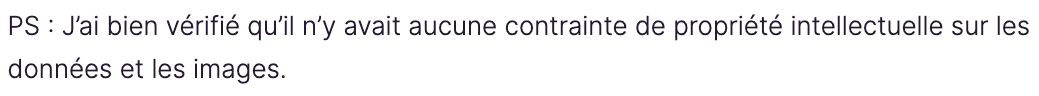

### Mettre en œuvre des techniques de réduction de dimension.

#### CE1 Vous avez justifié la nécessité de la réduction de dimension. 

- **Visualisation:** Difficile de visualiser des données en grande dimension
- **Efficacité computationnelle:** Dû à la malédiction de la dimensionnalité
- **Éviter le surapprentissage:** Le surapprentissage se produit lorsque le modèle apprend trop bien les détails et le bruit dans les données d'entraînement, au point qu'il se comporte mal sur les nouvelles données

#### CE2 Vous avez appliqué une méthode de réduction de dimension adaptée à la problématique (ex. : ACP). 

On va utiliser T-SNE

#### CE3 Vous avez justifié le choix des valeurs des paramètres dans la méthode de réduction de dimension retenue (ex. : le nombre de dimensions conservées pour l'ACP).  

Dans le mail de Linda est écrit la chose suivante:  
- "Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle ;"

On va donc prendre 2 dimensions, pour la valeur de perplexité à choisir, on va tester chaque valeur et regarder si la Silhouette et le Davies Bouldin est le meilleur

### Représenter graphiquement des données à grandes dimensions.

## A - Features images

In [71]:
images_features.head()

,uniq_id,category_lvl_1,0,1,2,3,4,5,6,7,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,3.398614,0.859573,0.0,1.106561,2.266123,2.927242,2.446446,0.0,...,0.485876,0.0,0.0,0.472938,0.875756,0.783684,0.000000,0.000000,0.851055,0.0
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,0.000000,0.000000,0.0,1.172009,0.000000,0.000000,0.000000,0.0,...,1.169695,0.0,0.0,0.000000,0.000000,3.152508,0.000000,0.000000,0.000000,0.0
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,0.000000,0.000000,0.0,4.457808,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,5.270286,0.000000,1.297099,0.000000,0.0
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,0.000000,0.070991,0.0,2.046283,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,3.977747,0.000000,0.000000,0.000000,0.0
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,3.417152,0.000000,0.0,0.000000,1.012359,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,9.195915,0.139736,0.000000,1.735951,0.0


#### CE1 Vous avez mis en œuvre au moins une technique de réduction de dimension (via LDA, ACP, T-SNE, UMAP ou autre technique).

Testons le T-SNE

On peut tester rapidement avec le PCA pour voir si on n'aurait pas de meilleurs résultats...

In [72]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

def visualize_pca(df):
    # Préparation des données
    features = df.drop(columns=['category_lvl_1', 'uniq_id'])  # supprimer la colonne des catégories pour isoler les caractéristiques
    labels = df['category_lvl_1']  # isoler les labels

    # Réalisation du PCA
    pca = PCA(n_components=2)  # créer l'objet PCA
    principalComponents = pca.fit_transform(features)  # ajuster et appliquer le PCA
    principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])  # création d'un nouveau dataframe avec les composantes principales

    # Ajout des labels au dataframe des composantes principales
    finalDf = pd.concat([principalDf, labels], axis=1)

    # Création du graphique
    plt.figure(figsize=(8,8))
    categories = finalDf['category_lvl_1'].unique()
    for category in categories:
        indicesToKeep = finalDf['category_lvl_1'] == category
        plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                    finalDf.loc[indicesToKeep, 'principal component 2'],
                    s=50,
                    edgecolor='white',
                    linewidths=0.5)

    plt.legend(categories)
    plt.grid(True)
    plt.show()

    # Calcul et affichage des scores de silhouette et de Davies-Bouldin
    sil_score = silhouette_score(features, labels)
    db_score = davies_bouldin_score(features, labels)

    print(f'Silhouette Score: {sil_score}')
    print(f'Davies Bouldin Score: {db_score}')

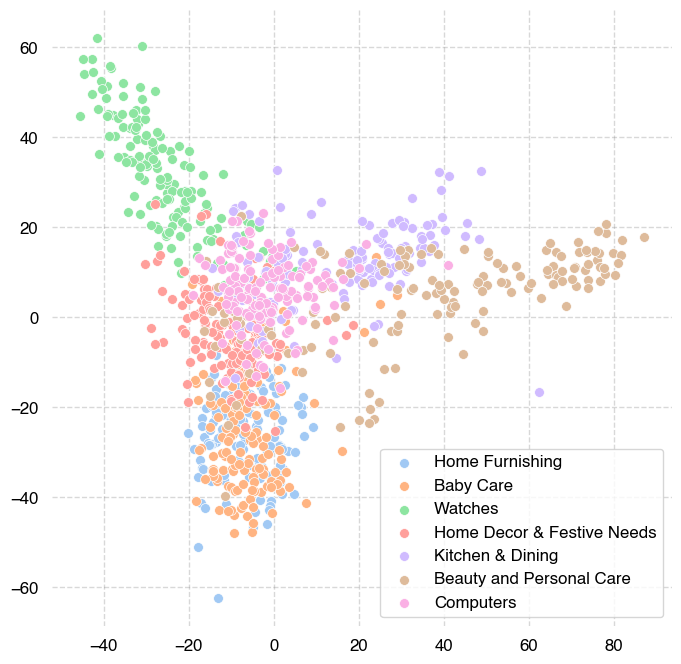

Silhouette Score: 0.05427735671401024
Davies Bouldin Score: 3.736147117591791


In [73]:
visualize_pca(df = images_features)

#### CE2 Vous avez réalisé au moins un graphique représentant les données réduites en 2D (par exemple affichage des 2 composantes du T-SNE).

In [74]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Les valeurs de perplexity qu'on peut éssayer
perplexities = range(5, 101, 5)

# Les valeurs de learning_rate qu'on peut éssayer
learning_rates = [10, 100, 1000]

# Les valeurs pour metric
metrics = ['euclidean', 'manhattan', 'chebyshev']

# Les valeurs pour init
inits = ['random', 'pca']

# Calcul du nombre total de combinaisons
total_combinations = len(perplexities) * len(learning_rates) * len(metrics) * len(inits)

# DataFrame pour stocker les résultats
results_df = pd.DataFrame(columns=['Perplexity', 'LearningRate', 'Metric', 
                                   'Init', 'Silhouette', 'DaviesBouldin'])

# Boucle sur toutes les combinaisons possibles
for perp in perplexities:
    for lr in learning_rates:
        for metric in metrics:
            for init in inits:
                tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, 
                            early_exaggeration=12.0, max_iter=1000, 
                            metric=metric, init=init, method='barnes_hut', random_state=42)
                tsne_results = tsne.fit_transform(images_features.drop(columns=['category_lvl_1', 'uniq_id']))

                # Calculer les scores pour cette configuration
                sil_score = silhouette_score(tsne_results, images_features['category_lvl_1'])
                db_score = davies_bouldin_score(tsne_results, images_features['category_lvl_1'])

                # Créer un DataFrame temporaire avec les résultats
                temp_df = pd.DataFrame([{'Perplexity': perp, 'LearningRate': lr, 
                                         'Metric': metric, 'Init': init, 
                                         'Silhouette': sil_score, 
                                         'DaviesBouldin': db_score}])

                # Ajouter les résultats dans le DataFrame en utilisant concat
                results_df = pd.concat([results_df, temp_df], ignore_index=True)

                # Afficher l'avancement
                print(f"Combinaison {len(results_df)} sur {total_combinations} effectuée.", end='\r', flush=True)
    

# Calculer les rangs
results_df['Rank_Silhouette'] = results_df['Silhouette'].rank(ascending=False)
results_df['Rank_DaviesBouldin'] = results_df['DaviesBouldin'].rank()

# Calculer la moyenne des rangs
results_df['Rank_Mean'] = results_df[['Rank_Silhouette', 'Rank_DaviesBouldin']].mean(axis=1)

# Trier le DataFrame en fonction du Rank_Mean et afficher les 10 premiers résultats
results_df.sort_values('Rank_Mean', inplace=True)
results_df.head(10)

/var/folders/bb/ndv932b13p9cm44kt8513n600000gn/T/ipykernel_57170/1144038890.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


,Perplexity,LearningRate,Metric,Init,Silhouette,DaviesBouldin,Rank_Silhouette,Rank_DaviesBouldin,Rank_Mean
261,75,100,manhattan,pca,0.260122,1.335097,3.0,1.0,2.0
201,60,10,manhattan,pca,0.267811,1.378185,1.0,4.0,2.5
271,80,10,euclidean,pca,0.249264,1.338879,4.0,2.0,3.0
189,55,100,manhattan,pca,0.260249,1.418421,2.0,5.0,3.5
133,40,100,euclidean,pca,0.234253,1.431473,10.0,6.0,8.0
188,55,100,manhattan,random,0.244530,1.493477,5.0,12.0,8.5
165,50,10,manhattan,pca,0.236550,1.489964,8.0,10.0,9.0
218,65,10,manhattan,random,0.238840,1.509511,7.0,14.0,10.5
97,30,100,euclidean,pca,0.233925,1.497026,11.0,13.0,12.0
229,65,1000,euclidean,pca,0.222946,1.377015,26.0,3.0,14.5


In [75]:
from sklearn.manifold import TSNE

# Préparation du t-SNE
tsne = TSNE(n_components=2, perplexity=60, learning_rate=10, 
                            early_exaggeration=12.0, n_iter=1000, 
                            metric='manhattan', init='pca', method='barnes_hut', random_state=42)

In [76]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

tsne_results = tsne.fit_transform(images_features.drop(columns=['category_lvl_1', 'uniq_id']))

# Création d'un nouveau DataFrame pour contenir les résultats du t-SNE
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Component 1', 'Component 2'])

# Ajouter la colonne des labels 'category_lvl_1' à tsne_df
tsne_df['category_lvl_1'] = images_features['category_lvl_1']

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


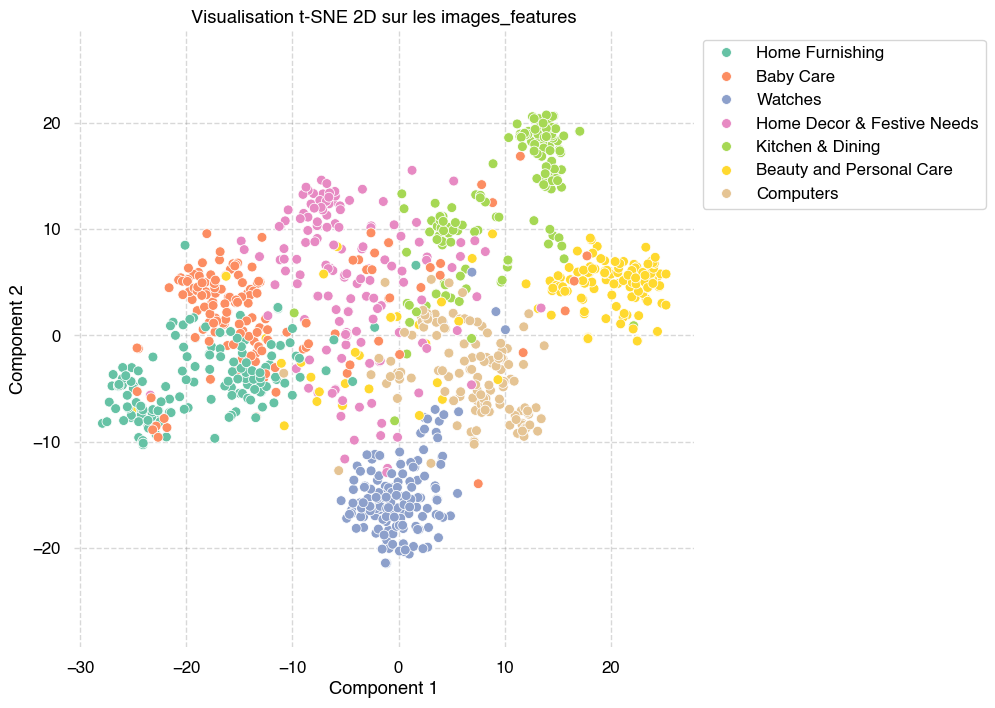

Silhouette Score:  0.26781088
Davies Bouldin Score:  1.3781854372159716


In [77]:
# Définir le nombre de catégories uniques
n_unique_categories = tsne_df['category_lvl_1'].nunique()

# Créer une palette avec le même nombre de couleurs que de catégories
palette = sns.color_palette("Set2", n_colors=n_unique_categories)

plt.figure(figsize=(8, 8))

# Utilisez la palette dans votre visualisation
scatter = sns.scatterplot(
    x="Component 1", y="Component 2",
    hue="category_lvl_1",
    palette=palette,
    data=tsne_df,
    legend="full",
    alpha=1,
    s=50)

# Déplacer la légende à l'extérieur du plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Ajouter un titre à votre visualisation
plt.title("Visualisation t-SNE 2D sur les images_features")

# Garantir que les échelles X et Y sont les mêmes
plt.axis('equal')
plt.show()

# Calculer le score de Silhouette
silhouette = silhouette_score(tsne_results, tsne_df['category_lvl_1'])
print("Silhouette Score: ", silhouette)

# Calculer l'indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(tsne_results, tsne_df['category_lvl_1'])
print("Davies Bouldin Score: ", davies_bouldin)

#### CE3 Vous avez réalisé et formalisé une analyse du graphique en 2D.

On peut effectuer un k-means (k = 7) et regarder si il y'a une bonne similarité en calculant son ARI (Adjusted Rand Index)

In [78]:
tsne_df

,Component 1,Component 2,category_lvl_1
0,-24.963219,-4.755413,Home Furnishing
1,-13.413644,-7.681941,Baby Care
2,-14.931688,-2.427512,Baby Care
3,-20.633701,-5.781188,Home Furnishing
4,-21.610260,-7.267265,Home Furnishing
...,...,...,...
1045,-24.638065,-5.291977,Baby Care
1046,-3.755923,7.133816,Baby Care
1047,-24.649092,-1.180610,Baby Care
1048,-4.292974,7.094068,Baby Care


In [79]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(tsne_df.drop(columns=['category_lvl_1']))

KMeans(n_clusters=7, n_init=100, random_state=42)

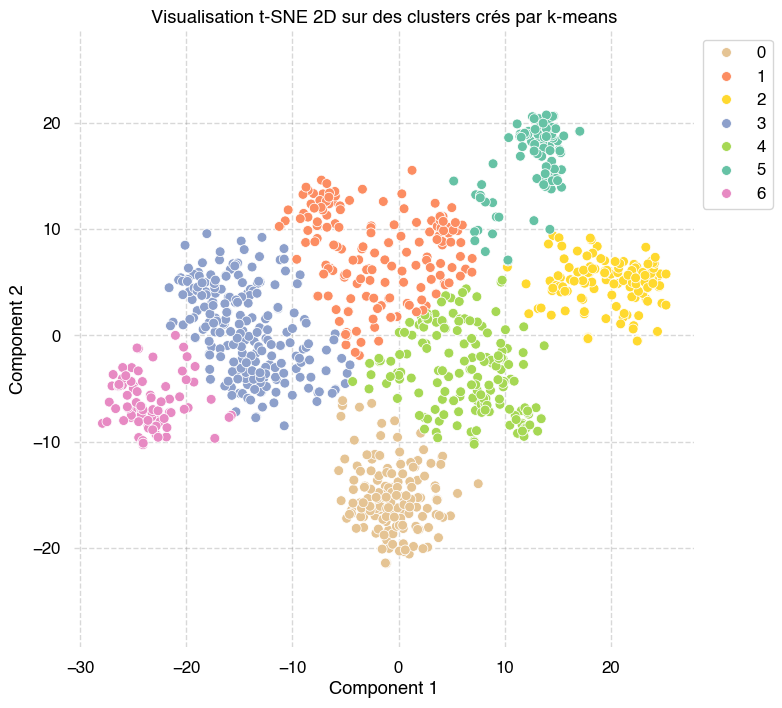

ARI :  0.5316792541211405


In [80]:
# Définir le nombre de catégories uniques
n_unique_categories = tsne_df['category_lvl_1'].nunique()

tsne_df["cluster"] = cls.labels_

# Créer une palette avec le même nombre de couleurs que de catégories
palette = sns.color_palette("Set2", n_colors=n_unique_categories)

# 2. Echangez les couleurs à l'aide d'une variable temporaire
temp = palette[3]
palette[3] = palette[6]
palette[6] = temp

temp = palette[3]
palette[3] = palette[0]
palette[0] = temp

temp = palette[3]
palette[3] = palette[5]
palette[5] = temp

temp = palette[3]
palette[3] = palette[2]
palette[2] = temp

plt.figure(figsize=(8, 8))

# Utilisez la palette dans votre visualisation
scatter = sns.scatterplot(
    x="Component 1", y="Component 2",
    hue="cluster",
    palette=palette,
    data=tsne_df,
    legend="full",
    alpha=1,
    s=50  # Taille des points
)

# Déplacer la légende à l'extérieur du plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Ajouter un titre à votre visualisation
plt.title("Visualisation t-SNE 2D sur des clusters crés par k-means")

# Garantir que les échelles X et Y sont les mêmes
plt.axis('equal')

plt.show()

labels = df["category_lvl_1"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

- L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
- Cette mesure de l'ARI (ordre de grandeur) a nécessité de créer des clusters théoriques via KMeans

In [81]:
palette 

[(0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

## B - Features textes

### Bert

#### CE1 Vous avez mis en œuvre au moins une technique de réduction de dimension (via LDA, ACP, T-SNE, UMAP ou autre technique)

Comme pour les features images on va rester sur T-SNE

In [82]:
# Ajout de la colonne "category_lvl_1" de df à df_bert
df_bert['category_lvl_1'] = df['category_lvl_1'].copy()

# Ajout de la colonne "uniq_id" de df à df_bert
df_bert['uniq_id'] = df['uniq_id'].copy()

In [83]:
df_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,category_lvl_1,uniq_id
0,-0.139285,-0.147112,0.584645,-0.053153,0.706819,0.024994,-0.043478,0.325798,-0.036617,-0.522964,...,0.297706,-0.210983,-0.144417,-0.064212,-0.129507,-0.266790,-0.042557,-0.171184,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7
1,0.010229,-0.123317,0.579820,0.066870,0.250622,0.032997,0.134588,0.040148,-0.046333,-0.078182,...,0.240299,-0.139958,-0.014386,-0.008773,-0.404847,-0.299267,-0.198612,0.027872,Baby Care,7b72c92c2f6c40268628ec5f14c6d590
2,-0.059171,-0.147463,0.507296,0.079291,0.365674,-0.155191,-0.134151,0.480830,-0.090870,-0.118901,...,0.238459,-0.251130,-0.002773,0.163428,-0.147737,-0.257123,-0.143233,-0.087481,Baby Care,64d5d4a258243731dc7bbb1eef49ad74
3,0.160119,-0.207000,0.697988,0.073262,0.482203,-0.229916,-0.154855,0.153520,-0.083500,0.100411,...,0.263556,-0.077329,0.031875,-0.058912,-0.524418,-0.132688,-0.008046,-0.184164,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8
4,0.112136,-0.004882,0.430160,-0.058560,0.533653,-0.308349,-0.108745,0.420066,0.004935,-0.123929,...,0.233091,-0.100965,-0.206244,0.155450,-0.409829,-0.242557,0.114111,-0.329055,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7


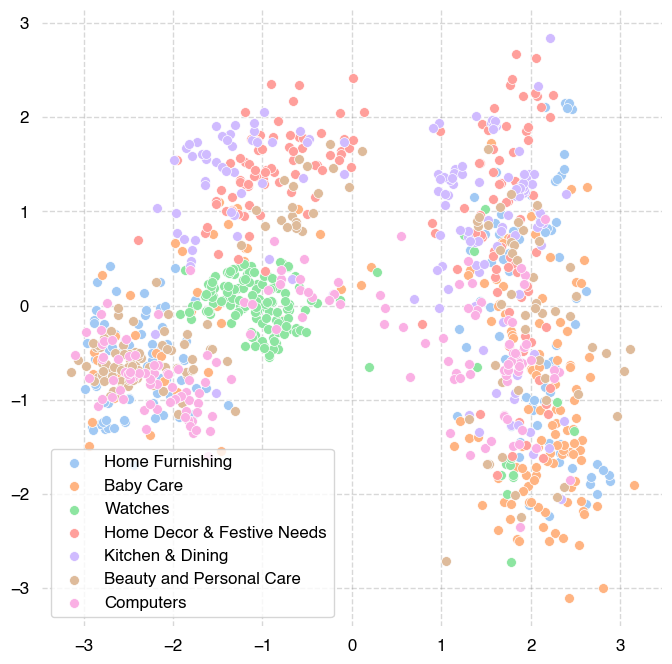

Silhouette Score: 0.052978724241256714
Davies Bouldin Score: 3.7648976589731893


In [84]:
visualize_pca(df = df_bert)

#### CE2 Vous avez réalisé au moins un graphique représentant les données réduites en 2D (par exemple affichage des 2 composantes du T-SNE).

In [85]:
results = tsne_grid_search(df_bert)
display(results)

/var/folders/bb/ndv932b13p9cm44kt8513n600000gn/T/ipykernel_57170/2437330205.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


,Perplexity,LearningRate,Metric,Init,Silhouette,DaviesBouldin,Rank_Silhouette,Rank_DaviesBouldin,Rank_Mean
60,20,100,euclidean,random,0.119115,4.194148,5.0,12.0,8.5
48,15,1000,euclidean,random,0.129633,4.390548,2.0,19.0,10.5
54,20,10,euclidean,random,0.132068,4.422533,1.0,20.0,10.5
50,15,1000,manhattan,random,0.121530,4.644498,3.0,24.0,13.5
68,20,1000,manhattan,random,0.112130,4.099764,19.0,9.0,14.0
56,20,10,manhattan,random,0.117913,4.484932,8.0,21.0,14.5
86,25,1000,manhattan,random,0.117162,4.680178,10.0,26.0,18.0
66,20,1000,euclidean,random,0.106577,3.915337,35.0,6.0,20.5
110,35,10,manhattan,random,0.104213,3.904009,38.0,5.0,21.5
36,15,10,euclidean,random,0.113784,4.961274,14.0,35.0,24.5


In [86]:
from sklearn.manifold import TSNE

# Préparation du t-SNE
tsne = TSNE(n_components=2,
            perplexity=15,
            learning_rate=1000, 
            early_exaggeration=12.0,
            max_iter=1000, 
            metric='euclidean',
            init='random',
            method='barnes_hut',
            random_state=42)

In [87]:
data = df

In [88]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

tsne_results = tsne.fit_transform(df_bert.drop(columns=['category_lvl_1', 'uniq_id']))

# Création d'un nouveau DataFrame pour contenir les résultats du t-SNE
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Component 1', 'Component 2'])

# Ajouter la colonne des labels 'category_lvl_1' à tsne_df
tsne_df['category_lvl_1'] = df_bert['category_lvl_1']

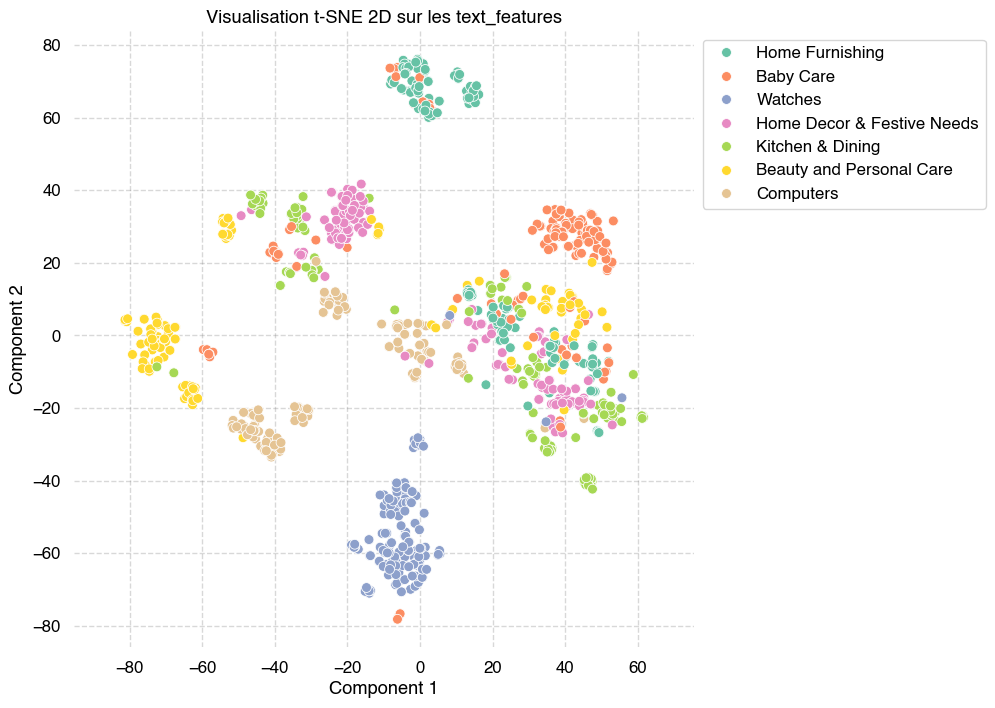

Silhouette Score:  0.12963292
Davies Bouldin Score:  4.390548159063626


In [89]:
# Définir le nombre de catégories uniques
n_unique_categories = tsne_df['category_lvl_1'].nunique()

# Créer une palette avec le même nombre de couleurs que de catégories
palette = sns.color_palette("Set2", n_colors=n_unique_categories)

plt.figure(figsize=(8, 8))

# Utilisez la palette dans votre visualisation
scatter = sns.scatterplot(
    x="Component 1", y="Component 2",
    hue="category_lvl_1",
    palette=palette,
    data=tsne_df,
    legend="full",
    alpha=1,
    s=50)

# Déplacer la légende à l'extérieur du plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Ajouter un titre à votre visualisation
plt.title("Visualisation t-SNE 2D sur les text_features")

# Garantir que les échelles X et Y sont les mêmes
plt.axis('equal')
plt.show()

# Calculer le score de Silhouette
silhouette = silhouette_score(tsne_results, tsne_df['category_lvl_1'])
print("Silhouette Score: ", silhouette)

# Calculer l'indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(tsne_results, tsne_df['category_lvl_1'])
print("Davies Bouldin Score: ", davies_bouldin)

#### CE3 Vous avez réalisé et formalisé une analyse du graphique en 2D.

On peut effectuer un k-means (k = 7) et regarder si il y'a une bonne similarité en calculant son ARI (Adjusted Rand Index)

In [90]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(tsne_df.drop(columns=['category_lvl_1']))

KMeans(n_clusters=7, n_init=100, random_state=42)

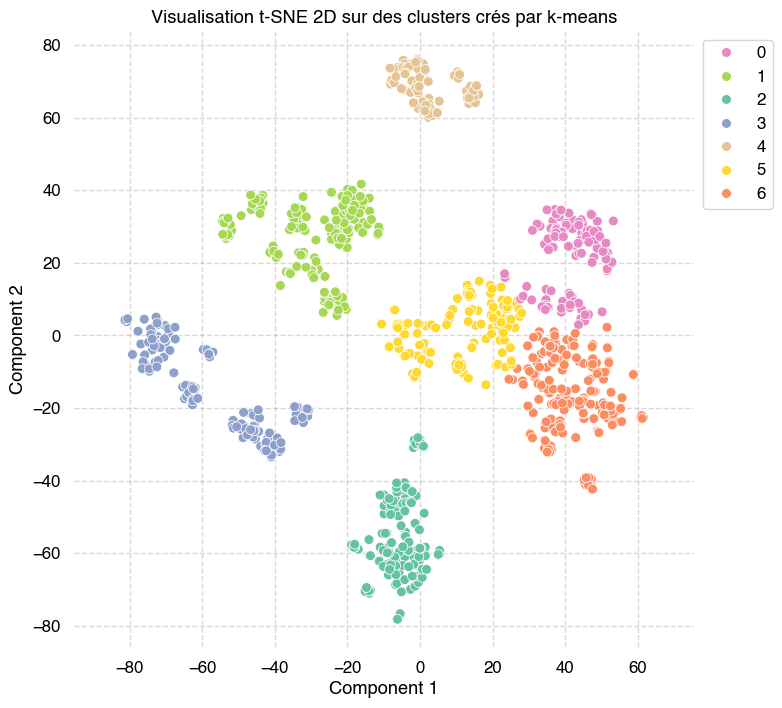

ARI :  0.34862910928950724


In [91]:
# Définir le nombre de catégories uniques
n_unique_categories = tsne_df['category_lvl_1'].nunique()

tsne_df["cluster"] = cls.labels_

# Créer une palette avec le même nombre de couleurs que de catégories
palette = sns.color_palette("Set2", n_colors=n_unique_categories)

# 2. Echangez les couleurs à l'aide d'une variable temporaire
temp = palette[0]
palette[0] = palette[2]
palette[2] = temp

temp = palette[0]
palette[0] = palette[3]
palette[3] = temp

temp = palette[1]
palette[1] = palette[6]
palette[6] = temp

temp = palette[1]
palette[1] = palette[4]
palette[4] = temp

plt.figure(figsize=(8, 8))

# Utilisez la palette dans votre visualisation
scatter = sns.scatterplot(
    x="Component 1", y="Component 2",
    hue="cluster",
    palette=palette,
    data=tsne_df,
    legend="full",
    alpha=1,
    s=50)

# Déplacer la légende à l'extérieur du plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Ajouter un titre à votre visualisation
plt.title("Visualisation t-SNE 2D sur des clusters crés par k-means")

# Garantir que les échelles X et Y sont les mêmes
plt.axis('equal')
plt.show()

labels = df["category_lvl_1"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### USE

#### CE1 Vous avez mis en œuvre au moins une technique de réduction de dimension (via LDA, ACP, T-SNE, UMAP ou autre technique)

Comme pour les features images on va rester sur T-SNE

In [92]:
# Ajout de la colonne "category_lvl_1" de df à df_bert
df_use['category_lvl_1'] = df['category_lvl_1'].copy()

# Ajout de la colonne "uniq_id" de df à df_bert
df_use['uniq_id'] = df['uniq_id'].copy()

In [93]:
df_use.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,category_lvl_1,uniq_id
0,-0.056370,-0.023049,0.017895,0.047665,0.027025,0.050614,-0.051162,0.058017,-0.023607,-0.009930,...,-0.055564,0.050154,-0.017514,-0.042019,0.025209,0.050283,0.047570,-0.013489,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7
1,-0.051229,-0.018987,0.012277,0.022975,0.057922,0.060340,0.057083,-0.022221,-0.047319,-0.047699,...,-0.054229,-0.056525,-0.019069,-0.052220,-0.005158,0.033082,0.031539,0.034636,Baby Care,7b72c92c2f6c40268628ec5f14c6d590
2,-0.058302,0.023299,-0.044487,0.054548,0.056491,0.057848,0.050587,0.044124,-0.024653,0.005472,...,-0.049861,0.002297,0.014810,-0.044659,0.044119,0.057874,-0.050333,-0.046317,Baby Care,64d5d4a258243731dc7bbb1eef49ad74
3,-0.055484,-0.052558,0.042706,0.052433,0.055371,0.047493,0.022774,0.032461,-0.008624,-0.051243,...,-0.007594,0.022513,-0.052632,-0.032311,0.052942,0.053591,-0.026310,-0.054579,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8
4,-0.055115,-0.037855,0.040429,0.049555,0.055062,0.053625,-0.028349,0.051057,0.034127,-0.050300,...,-0.050868,-0.026799,-0.054645,-0.040339,0.054859,0.055189,-0.019382,-0.052904,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7


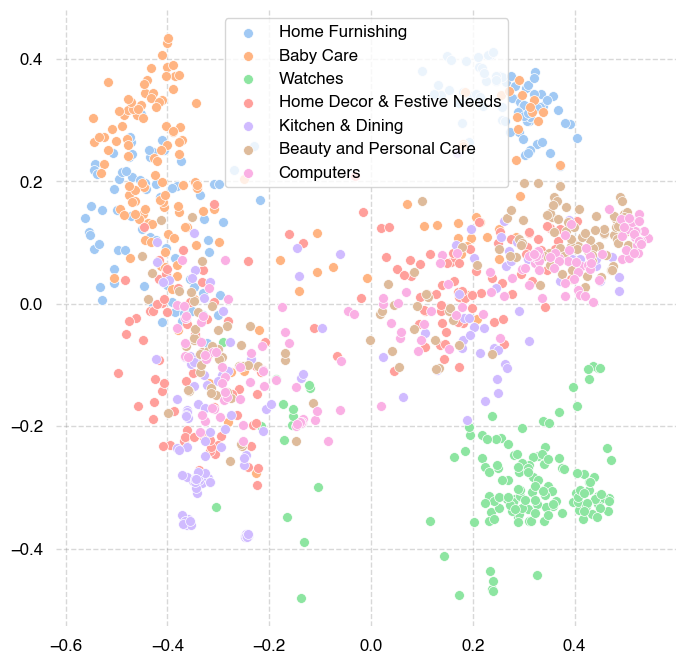

Silhouette Score: 0.0682748556137085
Davies Bouldin Score: 3.7049308714872136


In [94]:
visualize_pca(df = df_use)

#### CE2 Vous avez réalisé au moins un graphique représentant les données réduites en 2D (par exemple affichage des 2 composantes du T-SNE).

In [95]:
results = tsne_grid_search(df_use)
display(results)

/var/folders/bb/ndv932b13p9cm44kt8513n600000gn/T/ipykernel_57170/2437330205.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


,Perplexity,LearningRate,Metric,Init,Silhouette,DaviesBouldin,Rank_Silhouette,Rank_DaviesBouldin,Rank_Mean
80,25,100,manhattan,random,0.186243,3.060723,4.0,12.0,8.0
56,20,10,manhattan,random,0.188535,3.089640,3.0,13.0,8.0
121,35,1000,euclidean,pca,0.169759,3.026536,11.0,10.0,10.5
54,20,10,euclidean,random,0.183595,3.151404,6.0,15.0,10.5
72,25,10,euclidean,random,0.184422,3.357147,5.0,22.0,13.5
60,20,100,euclidean,random,0.193873,3.480144,2.0,27.0,14.5
43,15,100,euclidean,pca,0.161209,2.593928,26.0,3.0,14.5
42,15,100,euclidean,random,0.194836,3.724869,1.0,31.0,16.0
86,25,1000,manhattan,random,0.178553,3.415941,7.0,26.0,16.5
74,25,10,manhattan,random,0.176928,3.611297,8.0,29.0,18.5


In [96]:
from sklearn.manifold import TSNE

# Préparation du t-SNE
tsne = TSNE(n_components=2,
            perplexity=25,
            learning_rate=100, 
            early_exaggeration=12.0,
            max_iter=1000, 
            metric='manhattan',
            init='random',
            method='barnes_hut',
            random_state=42)

In [97]:
data = df

In [98]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

tsne_results = tsne.fit_transform(df_use.drop(columns=['category_lvl_1', 'uniq_id']))

# Création d'un nouveau DataFrame pour contenir les résultats du t-SNE
tsne_df = pd.DataFrame(data = tsne_results, columns = ['Component 1', 'Component 2'])

# Ajouter la colonne des labels 'category_lvl_1' à tsne_df
tsne_df['category_lvl_1'] = df_bert['category_lvl_1']

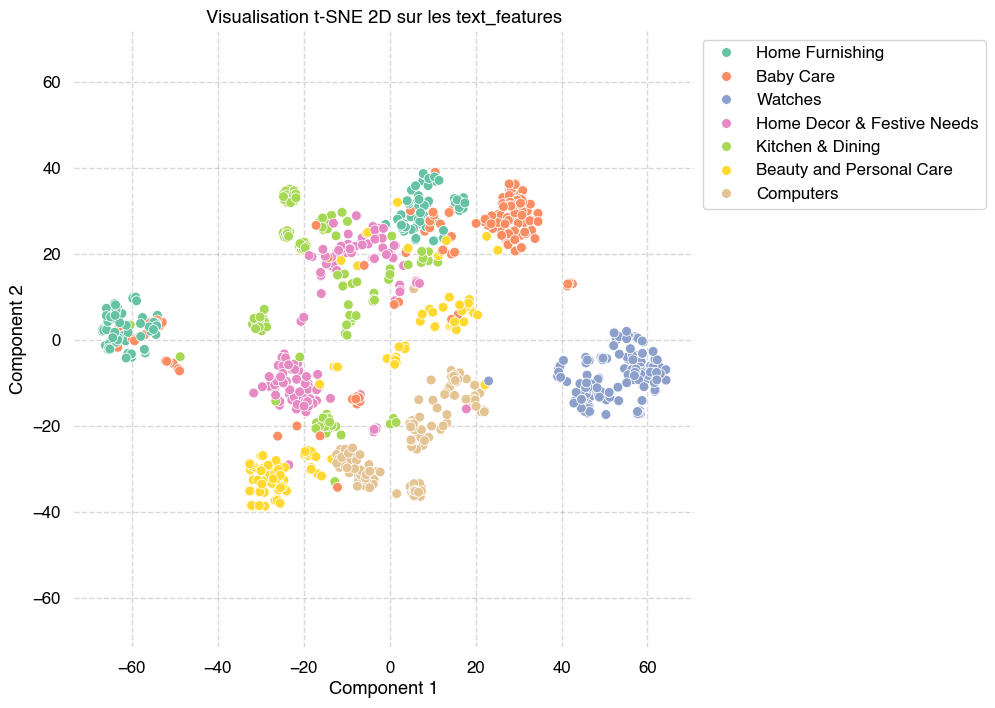

Silhouette Score:  0.18624334
Davies Bouldin Score:  3.060722934899448


In [99]:
# Définir le nombre de catégories uniques
n_unique_categories = tsne_df['category_lvl_1'].nunique()

# Créer une palette avec le même nombre de couleurs que de catégories
palette = sns.color_palette("Set2", n_colors=n_unique_categories)

plt.figure(figsize=(8, 8))

# Utilisez la palette dans votre visualisation
scatter = sns.scatterplot(
    x="Component 1", y="Component 2",
    hue="category_lvl_1",
    palette=palette,
    data=tsne_df,
    legend="full",
    alpha=1,
    s=50)

# Déplacer la légende à l'extérieur du plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Ajouter un titre à votre visualisation
plt.title("Visualisation t-SNE 2D sur les text_features")

# Garantir que les échelles X et Y sont les mêmes
plt.axis('equal')
plt.show()

# Calculer le score de Silhouette
silhouette = silhouette_score(tsne_results, tsne_df['category_lvl_1'])
print("Silhouette Score: ", silhouette)

# Calculer l'indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(tsne_results, tsne_df['category_lvl_1'])
print("Davies Bouldin Score: ", davies_bouldin)

#### CE3 Vous avez réalisé et formalisé une analyse du graphique en 2D.

On peut effectuer un k-means (k = 7) et regarder si il y'a une bonne similarité en calculant son ARI (Adjusted Rand Index)

In [100]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
cls.fit(tsne_df.drop(columns=['category_lvl_1']))

KMeans(n_clusters=7, n_init=100, random_state=42)

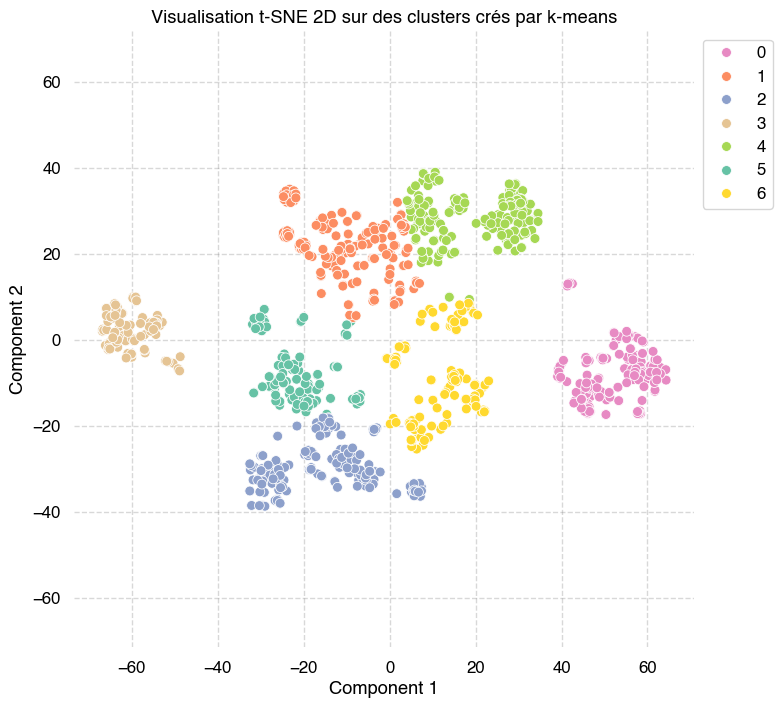

ARI :  0.4222650122665023


In [101]:
# Définir le nombre de catégories uniques
n_unique_categories = tsne_df['category_lvl_1'].nunique()

tsne_df["cluster"] = cls.labels_

# Créer une palette avec le même nombre de couleurs que de catégories
palette = sns.color_palette("Set2", n_colors=n_unique_categories)

# 2. Echangez les couleurs à l'aide d'une variable temporaire
temp = palette[0]
palette[0] = palette[5]
palette[5] = temp

temp = palette[0]
palette[0] = palette[3]
palette[3] = temp

temp = palette[6]
palette[6] = palette[3]
palette[3] = temp

plt.figure(figsize=(8, 8))

# Utilisez la palette dans votre visualisation
scatter = sns.scatterplot(
    x="Component 1", y="Component 2",
    hue="cluster",
    palette=palette,
    data=tsne_df,
    legend="full",
    alpha=1,
    s=50  # Taille des points
)

# Déplacer la légende à l'extérieur du plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Ajouter un titre à votre visualisation
plt.title("Visualisation t-SNE 2D sur des clusters crés par k-means")

# Garantir que les échelles X et Y sont les mêmes
plt.axis('equal')
plt.show()

labels = df["category_lvl_1"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Les résultats sont meilleurs, mais les features images donnent de meilleurs résultats en général

# Conclusion

Les features images ont permis de montrer qu'il est possible d'obtenir des clusters en 2D -> Classification supervisée possible